# Deal-Sourcing from from HackerNews: Who's Hiring


## Scraper 

In [298]:
from bs4 import BeautifulSoup
from base64 import b64decode
import glob
import json
import os
import requests
import time
from tqdm import tqdm
import backoff

In [299]:
DOMAIN = 'https://news.ycombinator.com/'
PAGES = {
    # Considering companies that are hiring in 2022-2023 since those are the companies that are most likely to be currently active for consideration for Series A Funding
    'whoishiring': DOMAIN + 'submitted?id=whoishiring',
    'listings': DOMAIN + 'item?id={item_id}&p={page}',
}

### Zyte: For Web Scraping
Scraping always involves a delicate balance between data collection and respecting the website's resources and policies. When using Zyte's Scrapy Cloud platform, following their guidelines and best practices will help avoid getting banned or hitting rate limits, ensuring a smoother and more efficient web scraping process.

In [300]:
ZYTE_API_KEY = "WITHDRAWN"
def get_zyte_request(url):
    api_response = requests.post(
        "https://api.zyte.com/v1/extract",
        auth=(ZYTE_API_KEY, ""),
        json={
            "url": url,  
            "httpResponseBody": True 
        },
    )
    http_response_body: bytes = b64decode(
        api_response.json()["httpResponseBody"])
    return http_response_body

### URL Queue
A URL Queue to collect and execute scraping on paginated webpages of hackerrank - who is hiring. 

In [301]:
class URLQueue:
    def __init__(self):
        self.queue = []

    def is_empty(self):
        return len(self.queue) == 0

    def enqueue(self, url):
        self.queue.append(url)

    def dequeue(self):
        if not self.is_empty():
            return self.queue.pop(0)  
        return None
    
    def peek(self):
        if not self.is_empty():
            return self.queue[0]
        return None

    def size(self):
        return len(self.queue)

#### listings (dict)
- `key`: Listing title e.g: ```"Ask HN: Who is hiring? (July 2023)"```
- `value`: List of comments that are at indent 1 *(This ignores comments with indent 2+ as they are replies and are left out of the scope of this project)*

#### get_next_page(url)
It is a common utility function for page of type `whoishiring` or `listings`, the HTML follows the same format for the `morelink` attribute to get the link to the next page. 

#### process_page(url, queue, mode)
The function to get the links of the pages attached to it, and to process the relevant information. This has two different modes of operations `whoishiring` and `listings`
- the `whoishiring` pages contain the links to the `listings` page, we only consider the Hiring posts and **not** the Freelancer/Want to be hired posts. These pages are then queued. 
- the `listings` pages contain the actual listing to be scraped, along with the next page which is added to the queue. 

In [302]:
listings = {}
@backoff.on_exception(backoff.expo, requests.exceptions.RequestException, max_tries=5)
def get_next_page(url):
    page = get_zyte_request(url)
    soup = BeautifulSoup(page.decode("utf-8"), 'html.parser')
    # Find the element with class "morelink"
    morelink_element = soup.find('a', {'class': 'morelink'})
    # Extract the href attribute if the element is found
    if morelink_element:
        href_value = morelink_element.get('href')
        return href_value
    else:
       return None

@backoff.on_exception(backoff.expo, requests.exceptions.RequestException, max_tries=5)
def process_page(url, queue, mode="whoishiring"):
    page = get_zyte_request(url)
    if not page:
        return queue
    soup = BeautifulSoup(page.decode("utf-8"), 'html.parser')
    if mode=="whoishiring":
        posts = soup.find_all(class_="athing")
        for post in posts:
            if post and post.find('span', {'class': 'titleline'}):
                a_block = post.find('span', {'class': 'titleline'}).find('a')
                link = DOMAIN + a_block.get('href')
                if 'hiring' in a_block.get_text().lower():
                    queue.enqueue(link)
    elif mode=="listings":
        key = soup.find('tr', {'id': 'pagespace'}).get('title')
        if key not in listings:
            listings[key] = []
        comments = soup.find_all(class_="athing comtr")
        for comment in comments:
            if comment.find('td', {'class': 'ind', 'indent': '0'}) and comment.find('span', {'class': 'commtext c00'}):
                comment_text = comment.find('span', {'class': 'commtext c00'}).get_text(separator='\n')

                listings[key].append(comment_text)
            
    else:
        raise ValueError("mode must be either 'whoishiring' or 'listings'")
    return queue

#### get_urls_to_scrape(queue) 
This function exhausts the queue passed in the argument and processes the two different modes of pages `whoishiring` and `listings`, and adds the next page of the `listings` pages and processes them all. 

In [303]:
def get_urls_to_scrape(queue):
    while not queue.is_empty():
        current_url = queue.peek()
        if "whoishiring" in current_url:
            queue = process_page(current_url, queue, mode="whoishiring")
        else:
            queue = process_page(current_url, queue, mode="listings")
            next_url = get_next_page(current_url)
            if next_url is not None:
                new_url = DOMAIN + next_url
                queue.enqueue(new_url)
        queue.dequeue()
    return queue

#### Processing May 2020 to Aug 2023
We will iterate through the first 4 pages of the `whoishiring` posts, to cover May 2020 to Aug 2023. 
For the scope of this project, we will end up only leveraging posts from 2022-2023, since they will likely be most relevant for potential investments, and also to adhere to the computational limitations of the resources at hand. 

In [306]:
url_queue = URLQueue()
current_page = PAGES['whoishiring']
for i in range(4):
    print(f"Scraping page {i+1} of {4}")
    url_queue.enqueue(current_page)
    url_queue = get_urls_to_scrape(url_queue)
    next_blurb = get_next_page(current_page)
    if next_blurb is not None:
       next_page = DOMAIN + next_blurb
    else:
        break
    current_page = next_page

Scraping page 1 of 4
Scraping page 2 of 4
Scraping page 3 of 4
Scraping page 4 of 4


In [ ]:
import re
updated_listings_data = {}

# Update the keys to remove "Ask HN: Who is hiring?" and keep only the month and year
for key, listing in listings.items():
    month_and_year = re.search(r'\((.*?)\)', key).group(1).strip()
    updated_listings_data[month_and_year] = listing

with open("listings.json", "w") as fp:
    json.dump(updated_listings_data, fp)

In [307]:
import matplotlib.pyplot as plt
def plot_dict_with_count(dictionary, title):
    """Plot a dictionary with the keys as x-axis and the values as y-axis"""
    # Extract the x and y data for plotting
    x = list(dictionary.keys())
    y = [len(dictionary[key]) for key in x]

    # Create the plot
    plt.figure(figsize=(12, 5))
    plt.bar(x, y, color='skyblue')
    plt.xlabel('Month and Year')
    plt.ylabel('Number of Listings')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()

The keys in listings: dict_keys(['August 2023', 'July 2023', 'June 2023', 'May 2023', 'April 2023', 'March 2023', 'February 2023', 'January 2023', 'December 2022', 'November 2022', 'October 2022', 'September 2022', 'August 2022', 'July 2022', 'June 2022', 'May 2022', 'April 2022', 'March 2022', 'February 2022', 'January 2022', 'December 2021', 'November 2021', 'October 2021', 'September 2021', 'August 2021', 'July 2021', 'June 2021', 'May 2021', 'April 2021', 'March 2021', 'February 2021', 'January 2021', 'December 2020', 'November 2020', 'October 2020', 'September 2020', 'August 2020', 'July 2020', 'June 2020', 'May 2020'])
The total number of listings from May 2020 to Aug 2023: 25391


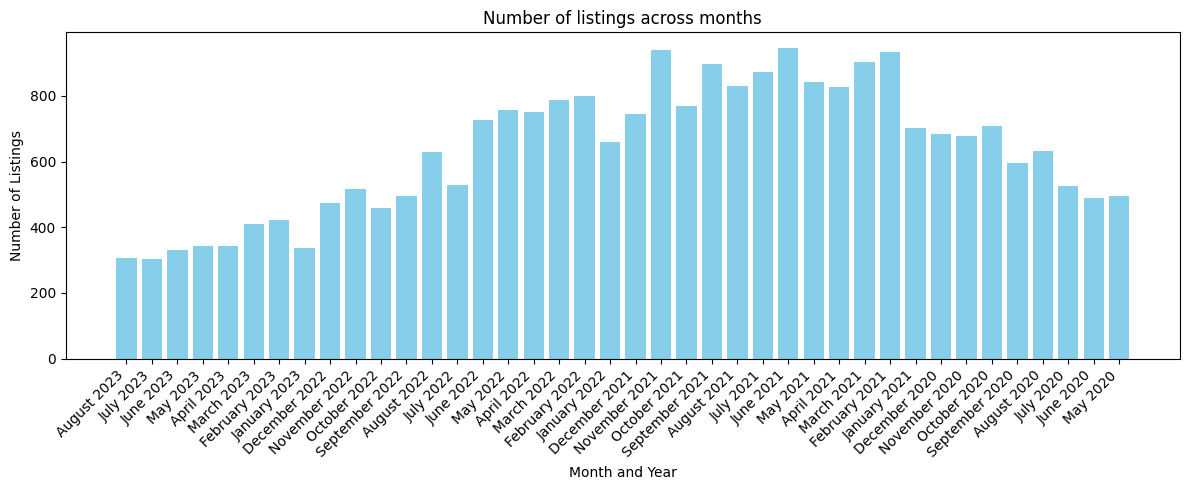

In [309]:
print(f"The keys in listings: {listings.keys()}")
print(f"The total number of listings from May 2020 to Aug 2023: {sum([len(x) for x in listings.values()])}")
plot_dict_with_count(listings, "Number of listings across months")


### Sanity Checks 
Tests to ensure that the data is properly scraped
1. We ensure it has all the months between May 2020-August 2023 (These pages are expected from the first 4 `whoishiring` pages at the time of scraping)
2. Backblaze is present in the value of the key containing September 2022. This is one of the listings for the month that is in the last pages of September 2022. It ensures that all pages were pulled. (Atleast for Sept 2022 in this spot check!)
3. Similarly Cocoon is in the listing in one of the middle pages for August 2023. 

In [310]:
import unittest
class TestScrapedData(unittest.TestCase):
    def test_month_range(self):
        # Test 1: listings.keys() contains all months between August 2023 to May 2020
        all_months = set([
            'August 2023', 'July 2023', 'June 2023', 'May 2023', 'April 2023', 'March 2023', 'February 2023', 'January 2023',
            'December 2022', 'November 2022', 'October 2022', 'September 2022', 'August 2022', 'July 2022', 'June 2022',
            'May 2022', 'April 2022', 'March 2022', 'February 2022', 'January 2022', 'December 2021', 'November 2021',
            'October 2021', 'September 2021', 'August 2021', 'July 2021', 'June 2021', 'May 2021', 'April 2021', 'March 2021',
            'February 2021', 'January 2021', 'December 2020', 'November 2020', 'October 2020', 'September 2020', 'August 2020',
            'July 2020', 'June 2020', 'May 2020'
        ])
        self.assertEqual(set(listings.keys()), all_months)

    def test_backblaze_in_september_2022(self):
        flag = False
        # Test 2: Backblaze is present in the value of the key containing September 2022
        for s in listings["{month}".format(month="September 2022")]:
            if  'Backblaze' in s:
                flag = True
                break
        self.assertTrue(flag)

    def test_cocoon_in_august_2023(self):
        flag = False
        # Test 3: Cocoon is present in the value of the key containing August 2023
        for s in listings["{month}".format(month="August 2023")]:
            if 'Cocoon' in s:
                flag = True
                break
        self.assertTrue(flag)

if __name__ == '__main__':
    suite = unittest.TestLoader().loadTestsFromTestCase(TestScrapedData)
    # Create a TextTestRunner and run the tests
    runner = unittest.TextTestRunner(verbosity=2)
    runner.run(suite)

test_backblaze_in_september_2022 (__main__.TestScrapedData) ... ok
test_cocoon_in_august_2023 (__main__.TestScrapedData) ... ok
test_month_range (__main__.TestScrapedData) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.005s

OK


## Data Preparation
Now that we have the scraped comments, we need to structure them into a `Listing` class. 
- `company_name` that is extracted from a line separated by "|" and is usually the first entity. 
- `location` that is extracted using **Named Entity Recognition** 
- `is_europe` that is a flag that detects whether the given location is in Europe. (Since the firm is focussed on Series A companies in Europe.)
- `keywords` that aim to extract the domain, field, specific technologies as keywords from the comments. This is then later explored as an embedding vector to cluster companies. 
- `description` is simply the entire comment, if at all it can be useful in its raw form for future manipulation. 
- `date` captures which month, year the listing was posted

We also store the scraped listings as `listings.json` that can be easily loaded.

In [369]:
with open("listings.json", "r") as f:
    listings = json.load(f)

from typing import List

class Listing:
    def __init__(self, company_name: str, location: List[str], is_europe: bool, keywords: List[str], description: str, date: str, keyword_embedding: List[float] = None):
        self.company_name = company_name
        self.location = location
        self.is_europe = is_europe
        self.keywords = keywords
        self.description = description
        self.date = date
        self.keyword_embedding = keyword_embedding

## Named Entity Recognition 
The next section explores using spacy, pytextrank, Rake libraries for extracting the necessary information from the listing text into a `Listing` class with the relevant attributes.

### Data Pre-processing 
To truly capture the semantics of a name, noise/additional characters are removed and standard preprocessing techniques are employed. 
- Punctuation and Special Characters are removed
- Sentence is tokenized
- Converted to lowercase 
- Stopwords are removed
- Lemmatization (root words)

In [312]:
import random
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_sentence(sentence):
    # Remove punctuation
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    sentence = sentence.translate(translator)
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    # Tokenize the sentence
    tokens = nltk.word_tokenize(sentence)
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join the tokens back into a sentence
    preprocessed_sentence = ' '.join(tokens)
    return preprocessed_sentence

[nltk_data] Downloading package punkt to /Users/meg-kumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/meg-
[nltk_data]     kumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/meg-
[nltk_data]     kumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Keyword Extraction Method
Experimenting with different keyword extraction methods and comparing results for a random sample of 5 job listings

#### KeyBERT
KeyBERT is a keyword extraction technique based on BERT embeddings, which utilizes contextual information to identify the most relevant keywords or key phrases from a given text.

In [317]:
from keybert import KeyBERT
kw_model = KeyBERT()

def keywords_extraction_keybert(text):
    text = preprocess_sentence(text)
    keywords = kw_model.extract_keywords(text, top_n=40)
    return [k[0] for k in keywords]

#### TextRank 
TextRank is an unsupervised graph-based algorithm that ranks words or phrases in a text by analyzing their co-occurrence patterns, providing an automated way to extract important keywords or key phrases.

In [314]:
import pytextrank
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp_textrank = spacy.load("en_core_web_sm")
nlp_textrank.add_pipe("textrank")

def keywords_extraction_textrank(text):
    text = preprocess_sentence(text)
    doc = nlp_textrank(text)
    # examine the top-ranked phrases in the document
    phrases = [phrase.text for phrase in doc._.phrases[:50] if phrase.text.lower() not in STOP_WORDS]
    return ", ".join(phrases)


In [319]:
test_texts = [r for r in random.sample(listings['July 2023'], 3)]
for t in test_texts:
    print(t)
    print('---')
    print(keywords_extraction_keybert(t))
    print('---')
    print(keywords_extraction_textrank(t))

Relay.club | AI Software Engineer | REMOTE | Full-time | 
https://www.relay.club/
LOCATION: Fully remote
TECH STACK: OpenAI, Typescript, NextJS, React, Supabase
We're relay.club, an influencer management platform that connects brands with social media influencers. We're a small and growing startup that has raised over $350,000 in our first round of funding.
Workplace satisfaction, code quality, and professional development are important to us. Strong company culture of empowerment.
► AI Senior Software Engineer
Show a job or personal project using the OpenAI API.
► AI Apprentice Software Engineer
For early career devs and coding camp new graduates. Show a personal project using the OpenAI API.
Our hiring process takes about three hours and consists of only interviews and a one-hour mock code review.
Job descriptions: 
https://hiring-relay-club.pages.dev/
  Interested? Email our COO, sophia@relay.club.
---
['hiring', 'openai', 'supabase', 'apprentice', 'engineer', 'relay', 'tech', 'api'

Upon inspection of the keywords, `textrank` seems to offer a better perspective into what might actually be useful for determining the factors that would influence whether a company would be a good investment or not. `textrank` gives phrases that cover concepts across what field/domain the company is in, what roles are open, core values of company, tech stack, company culture. But `keybert` on the other hand gives single word keywords that don't give a deeper dive into what the company stands for. Like this example below:

`textrank`
> apple com u, human progress medicine mission, remote san diego new york boston full time condor building world finance, time money life, also good human interested mission u http bit, condor software software engineer, big hairy complex business domain value building code easy delete geek, podcast episode, biotech finance team, clinical trial deployment growth demand, resume link project, full stack django, inefficient financial process, edge therapy market, currently service looking product leaning software engineer, new york, life, san diego, six level http, condor220801, boston, treatment, 1 six level skilled people, faster affordably started condor, billion dollar, 1 six

`keybert`

> 'condorsoftware', 'condor', 'condor220801', 'biotech', 'engineer', 'software', 'career', 'progress', 'mission', 'django', 'resume', 'stack', 'podcast', 'skilled', 'medicine', 'podcasts', 'service', 'financial', 'affordably', 'finance', 'geek', 'note', 'deployment', 'level', 'joining', 'process', 'demand', 'market', 'life', 'looking', 'business', 'clinical', 'started', 'inefficient', 'building', 'world', 'money', 'apple', 'interested', 'product'

#### Future Scope
- We have currently compared off-the-shelf libraries for keywords extraction and selected the most reasonable one among them. 
- We could train specific models finetuned in extracting keywords for `tech stack`, `domain/field`, `size of company`, `viability in the market`, `growth`. We would need **labelled dataset** to finetune existing keyword extraction frameworks, or build custom models and then train them with our labelled dataset developed for each of these specific use-cases. 

#### Determining Location
- we use `geopy` and `pycountry` to determine and organize the locations extracted from **Named Entity Recognition** with `spacy`

In [363]:
from geopy.geocoders import Nominatim
import pycountry
import pycountry_convert as pc
from geopy.exc import GeocoderTimedOut
import time

# Load the English language model for spaCy
nlp = spacy.load("en_core_web_sm")
geolocator = Nominatim(user_agent="location_finder_app")

# Function to determine if a location is in Europe using Nominatim
def is_location_in_europe(location):
    for l in location:
        try:
            location_info = geolocator.geocode(l)
            country_name = location_info.address.split(",")[-1].strip()
            country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
            continent_name = pc.country_alpha2_to_continent_code(country_code)
            if continent_name == "EU":
                return True        
        except Exception as e:
            pass
    return False


def geocode_locations(location_entities):
    location_candidates = []
    for location in location_entities:
        try:
            location_info = geolocator.geocode(location, exactly_one=True, timeout=10)
            if location_info:
                location_candidates.append(location_info.address)
        except (GeocoderTimedOut, Exception) as e:
            pass
        time.sleep(1)  # Add a delay between requests to avoid overloading the geocoding service
    return location_candidates

The following examples demonstrate that the function returns True if `any` of the locations are in Europe. 

In [332]:
is_location_in_europe(['New York', 'Delhi', 'San Francisco, Vue', 'Paris', 'Typescript'])

True

In [322]:
is_location_in_europe(['New York', 'Delhi', 'San Francisco, Vue', 'Australia', 'Typescript'])

False

In [362]:
import re
# Function to parse job listing with NER and extract attributes

def parse_job_listing_with_ner(text):
    is_europe = False
    
    eol_first = text.find('\n')
    first_line = text[:eol_first]
    if '|' in first_line:
        company_name = first_line.split('|')[0].strip()
    else:
        company_name = first_line.split(" ")[0].strip()

    doc = nlp(text)
    # Extract location entities from NER GPE
    location_entities = [ent.text for ent in doc.ents if ent.label_ == "GPE"]

    # Check if location is in Europe
    if location_entities:
        location_candidates = geocode_locations(location_entities)
        is_europe = is_location_in_europe(location_candidates)
    else:
        location_candidates = []

    # Extract keywords using the provided keywords_extraction function
    keywords = keywords_extraction(text)

    # Description is the text itself
    description = text
    return Listing(company_name, location_candidates, is_europe, keywords, description, "")

In [324]:
for title, month_listings in listings.items():
    # For the scope of this project, extract only 2022 and 2023 listings
    if title.split()[-1] == "2022" or title.split()[-1] == "2023":
        for listing in tqdm(month_listings):
            listing_object = parse_job_listing_with_ner(listing)
            listing_object.date = title
            listing_objects.append(listing_object)
            pass

100%|██████████| 659/659 [00:00<00:00, 359293.69it/s]


In [333]:
listing_tests = random.sample(listing_objects, 3)
for l in listing_tests:
    print(l.location)
    print(l.is_europe)
    print(l.keywords)

['Canada', 'React, Łódź-Śródmieście, Łódź, województwo łódzkie, Polska', 'Redux, Napa County, CAL Fire Northern Region, California, United States', 'Docker, South Lakeland, Westmorland and Furness, England, United Kingdom']
True
ep program, micro service experience relational database, devops mongodb aws gcp docker kubernetes, golang python django flask ruby rail, perfect fit preferred tech stack, cloud native distributed system, gcp docker kubernetes, skip technical interview, ton entrepreneurial spirit 5 year experience software engineering, ci cd, java scala, fe one vue j react redux, dev remote canada, explore, opportunity, one node j, canada, dev, right startup pool, http, 5 year, three month
['San Francisco, CAL Fire Northern Region, California, United States', 'City of New York, New York, United States', 'Los Angeles, Los Angeles County, CAL Fire Contract Counties, California, United States', 'Boston, Suffolk County, Massachusetts, United States', 'Catalyst, Catcliffe, Waverley,

### Bug Spotted
Oops! This classifies React, Redux, Docker as locations (because they ARE!) say hello to `Docker, South Lakeland, Westmorland and Furness, England, United Kingdom`. The library used does not spot them, although - there is an `importance` attribute available in `geopy` and while I was crunched for time to rerun it on the whole thing, here is what a potential solve would look like... 

In [340]:
### BEFORE
test = listing_tests[0]
test_text = test.description
test_listing = parse_job_listing_with_ner(test_text)
test_listing.location

['CANADA', 'React', 'Redux', 'Docker', 'NoSQL']


['Canada',
 'React, Łódź-Śródmieście, Łódź, województwo łódzkie, Polska',
 'Redux, Napa County, CAL Fire Northern Region, California, United States',
 'Docker, South Lakeland, Westmorland and Furness, England, United Kingdom']

#### Potential Solve
- Only keep locations with a high importance score (> 0.7)

In [341]:
def geocode_locations(location_entities):
    location_candidates = []
    for location in location_entities:
        try:
            location_info = geolocator.geocode(location, exactly_one=True, timeout=10)
            # Only keep locations with a high importance score
            if location_info and location_info.raw["importance"] > 0.7:
                location_candidates.append(location_info.address)
        except (GeocoderTimedOut, Exception) as e:
            pass
        time.sleep(1)  # Add a delay between requests to avoid overloading the geocoding service
    return location_candidates

In [342]:
test = listing_tests[0]
test_text = test.description
test_listing = parse_job_listing_with_ner(test_text)
test_listing.location

['CANADA', 'React', 'Redux', 'Docker', 'NoSQL']
0.9661259109654082
0.3100099999999999
0.18500999999999992
0.44325697009425336


['Canada']

Awesome! Only Canada remains. 

(Note: I didn't have time to run it again with the rectification, so the data exploration below may be a little buggy when it comes to detecting European locations!)

In [252]:
import pickle

with open('hackernews_listings.pkl', 'wb') as f:
    pickle.dump(listing_objects, f)


In [325]:
with open('hackernews_listings.pkl', 'rb') as f:
    listing_objects = pickle.load(f)

### Sentence Transformers: Embeddings for Keywords
- Sentence Transformers are a class of pre-trained transformer-based models that encode textual data into dense vector representations (embeddings). They have been specifically designed to capture the semantic information and context of sentences, making them effective in capturing the nuances and meaning of individual keywords within company descriptions.

- This results in more informative and context-aware keyword representations, leading to better clustering performance.

- When using unsupervised learning techniques like K-means with Sentence Transformers embeddings, we can group similar keywords and, consequently, similar companies into clusters. The semantic information encoded in the embeddings enables the clustering algorithm to identify meaningful segments of different companies based on their descriptions. This allows for the discovery of inherent patterns and similarities between companies, aiding in market analysis, competitor identification, and other data-driven business insights.

In [256]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Load the Sentence Transformer model
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

In [373]:
# Embed the keywords using the Sentence Transformer model
embeddings = []
europe_listings = []
for listing in tqdm(listing_objects, desc="Embedding Keywords"):
    if listing.is_europe:
        europe_listings.append(listing)
        embeddings.append(model.encode(listing.keywords))

Embedding Keywords: 100%|██████████| 10627/10627 [00:00<00:00, 508155.60it/s]


In [374]:
import numpy as np
embeddings = np.vstack(embeddings)
embeddings.shape

(1999, 768)

The embeddings have `768` dimensions and we have a *slightly imperfect* algorithm that has determined `1999` listings with a true `is_europe` tag in 2022-2023

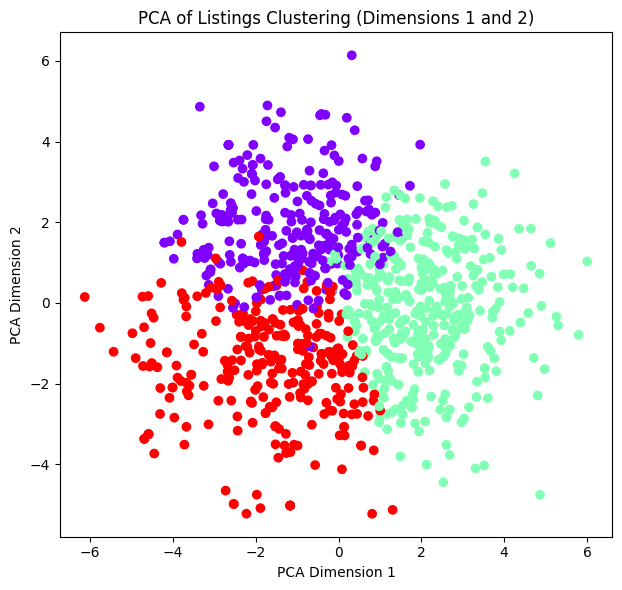

In [354]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply KMeans clustering to group the listings based on keyword similarity
num_clusters = 3  # You can adjust this number based on your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_indices = kmeans.fit_predict(embeddings)

# Perform PCA to reduce the embeddings to 3 dimensions
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

# Randomly select 1000 points from the embeddings array
sample_indices = random.sample(range(len(embeddings_3d)), 1000)
sample_embeddings_3d = embeddings_3d[sample_indices]

# Convert the cluster indices for the sampled points to a DataFrame
sample_cluster_indices = cluster_indices[sample_indices]

# Plot the PCA of embeddings in 3D - subplot 1
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(sample_embeddings_3d[:, 0], sample_embeddings_3d[:, 1], c=sample_cluster_indices, cmap='rainbow')
plt.title('PCA of Listings Clustering (Dimensions 1 and 2)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')

plt.tight_layout()
plt.show()

We have clusters that are semantically correlated with each other - but it doesn't necessarily tell us anthing about the potential success of the companies. 

### Supervised Learning
We have been working with an unsupervised dataset, since we don't actually know which companies would be successful or not. An opensource dataset is explored of successful investments and their details from [Kaggle: Startups Funding Dataset](https://www.kaggle.com/datasets/arpan129/startups-funding-dataset?resource=download)
Of course, the quality of this dataset can be improved by exploring other robust sources like `Crunchbase` or `Pitchbook`. 

Now we will encode the successful investments into the same Transformer model we have built. 

In [356]:
# Define the path to the folder containing the CSV files
folder_path_2020 = "data/startup-funding-data/2020"
folder_path_2021 = "data/startup-funding-data/2021"

# Function to read all CSV files in a folder and return the dataframe
def read_csv_files(folder_path):
    df_list = []
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            df_list.append(df)
    return pd.concat(df_list)

# Read CSV files for 2020 and 2021 and store them in dataframe
df_prev_years = pd.concat([read_csv_files(folder_path_2020), read_csv_files(folder_path_2021)], ignore_index=True)

# Encode the text data using SentenceTransformer and store the embeddings as a new column "funded_companies_embeddings"
df_prev_years['funded_companies_embeddings'] = df_prev_years.apply(lambda row: model.encode(f"{row['Industry/Vertical']}: {row['Sub-Vertical']}"), axis=1)

In [358]:
df_prev_years.head()


,Unnamed: 0,Startup Name,Founding Date,City,Industry/Vertical,Sub-Vertical,Founders,Investors,Amount(in USD),Investment Stage,0,1,2,3,4,5,6,7,8,funded_companies_embeddings
0,0,Aqgromalin,2019,Chennai,AgriTech,Cultivating Ideas for Profit,"Prasanna Manogaran, Bharani C L",Angel investors,"$200,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.16724615, 0.2870057, -0.35044473, -0.17276..."
1,1,Krayonnz,2019,Bangalore,EdTech,An academy-guardian-scholar centric ecosystem ...,"Saurabh Dixit, Gurudutt Upadhyay",GSF Accelerator,"$100,000",Pre-seed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.37713674, -0.22220612, 0.9945194, -0.58232..."
2,2,PadCare Labs,2018,Pune,Hygiene management,Converting bio-hazardous waste to harmless waste,Ajinkya Dhariya,Venture Center,Undisclosed,Pre-seed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.08373204, 0.084815495, -0.60105896, -0.451..."
3,3,NCOME,2020,New Delhi,Escrow,Escrow-as-a-service platform,Ritesh Tiwari,"Venture Catalysts, PointOne Capital","$400,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.27341348, -0.22515787, -0.19664867, -0.640..."
4,4,Gramophone,2016,Indore,AgriTech,Gramophone is an AgTech platform enabling acce...,"Ashish Rajan Singh, Harshit Gupta, Nishant Mah...","Siana Capital Management, Info Edge","$340,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.82995796, 0.3084408, -0.1001115, 0.0029207..."


#### Note
The supervised dataset is sourced from the Indian market, so the comparison of markets in Europe isn't entirely fair. The hypothesis for this expedition is that: **Successful domains/sub-verticals that have previously been funded, may be successful in European markets as well**

### Pairwise Nearest Neighbour Search
For each of the european companies from the listing, a nearest neighbour search of previously funded companies and their descriptions of sub-verticals is undertaken. If a match within a maximum threshold is found within its top 5 nearest neighbours, then it is considered a **viable** candidate for consideration. 

In [393]:
from sklearn.metrics.pairwise import cosine_distances

THRESHOLD = 0.35
candidates = []
for i, listing in enumerate(europe_listings):
    embedding = embeddings[i]

    # Calculate the cosine distance between the current embedding and all embeddings in df_prev_years
    distances = cosine_distances([embedding], list(df_prev_years["funded_companies_embeddings"].values))
    # Get the indices of the 5 nearest neighbors
    nearest_neighbors_indices = distances.argsort()[0][:5]
    # Check if any of the 5 nearest neighbors have a distance less than the threshold
    for idx in nearest_neighbors_indices:
        if distances[0, idx] < THRESHOLD:
            similar_company = df_prev_years.iloc[idx]
            candidates.append(f"Nearest neighbor distance: {distances[0, idx]}\n{listing.company_name} with keywords {listing.keywords}\n- Company: {similar_company['Startup Name']} | Sub-vertical: {similar_company['Sub-Vertical']}")
            break

for c in candidates[:5]:
    print(c)

Nearest neighbor distance: 0.32515352964401245
Genpax with keywords unique solution address challenge goal, infection control solution human animal healthcare, outbreak mrsa pathogen goal, full stack product engineer london uk, working high output team, www genpax co building game, early effective action, whole genome sequencing wgs data, biotech healthtech experience, london self motivated experience, proactive control, python graphql react typescript postgres aws, dangerous antibiotic resistant strain, necessary strong academic background, bacterial analysis platform, open minded adopting technology, interesting challenge, bioinformatics help hospital, sense ideal candidate, utility scalability speed, novel interactive tree, hybrid flexible http, stack, appropriate response, london, ing, touch, 55 100k equity based experience jfreeman, thing, fully scalable system, genpax, 100k, 55
- Company: Mestastop Solutions | Sub-vertical: Mestastop aims to provide a solution for such challenges

### Future Work 
1. **Feature Engineering**: The features selected in this iteration are `is_europe` determined through Named Entity Recognition and `keywords` obtained through a textrank algorithm for keywords extraction. These keywords are lumped together and cover a variety of concepts. We can do specific dimensions of feature extraction by training custom models to recognize niche concepts like: `tech stack`, `domain/field`, `size of company`, `viability in the market`, `growth`, `funding stage`, `employee satisfaction/turnover`. We would need **labelled dataset** to finetune existing keyword extraction frameworks, or build custom models and then train them with our labelled dataset developed for each of these specific use-cases. Each of these would be a custom-engineered feature, perhaps crafted with its own custom model. We can then either encode these features as embeddings or other encoding practices and use them to train a model - like a neural network or a random forest. 
2. **Supervised Dataset**: Free/open source resources for datasets for privileged information like funding/investments are harder to come by. A subscription to `Crunchbase`, `Pitchbook` or the likes to get validated, quality investment data - that covers a variety of factors - Market Opportunity, Competitive Advantage, Business Model, Market Traction, Exit Potential etc and building a comprehensive supervised model for each of these parameters would help evaluate new deals through each of those perspectives. We would need to work out how each of these different factors contribute to success, and how we would capture this information as features in a custom supervised dataset. When everyone has the same data, how we use the data is what differentiates! 
3. **Link Hopping**: A Series A focussed VC firm would target seed and pre-seed startups. This information is difficult to be determined straight from the job listing. But job listings usually have links to websites where we can learn more about the company itself. (rather than just the listing!) The job-listing can be used as a starting point to jumpstart then scrape information from the website of the company and curate even more detailed information about the company by building a more sophisticated scraping and parsing tool. 